## overview
- training a model using masking to predict missing values in order to evaluate patient's overall performance
- visualization for how prediction does overall compared to imputation as a baseline test

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import wandb
import statistics
from sklearn.model_selection import train_test_split
import random

Initialize run

Data

In [3]:
df = pd.read_csv("data/filtered_ds.csv")

In [4]:
df = df.sort_values(by=["patient_id", "start_time_min"])

Create training data

In [5]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [6]:
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1,14))
    scores = np.zeros((len(data), 14))
    i = 0
    
    data = data.sort_values(by=["start_time_min"])
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # set score to the score list average
        scores[i] = score
        i += 1
    
    scores_df = pd.DataFrame(scores, columns=["domain %d score" % i for i in range(1, 15)])
    data.reset_index(drop=True, inplace=True)
    scores_df.reset_index(drop=True, inplace=True)
    data = pd.concat([data, scores_df], axis=1)
    return data

In [7]:
data = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_85814/1806359856.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)


In [8]:
model_data = data[["domain %d score" % i for i in range(1, 15)]]

In [9]:
model_data

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,0.585,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
1,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
2,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.000,0.0,0.000,0.703,0.0
3,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.000,0.703,0.0
4,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.507,0.703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194129,0.000,0.0,0.63,0.800,0.613,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194130,0.000,0.0,0.63,0.800,0.626,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194131,0.000,0.0,0.63,0.800,0.652,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194132,0.000,0.0,0.63,0.800,0.690,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0


In [10]:
def filter_rows_by_list(data, column_name, value_list):
    """
    Filters rows in the DataFrame where the specified column's values are in the provided list.

    Parameters:
    - data (pd.DataFrame): The DataFrame to filter.
    - column_name (str): The name of the column to filter by.
    - value_list (list): A list of values to include in the filter.

    Returns:
    - pd.DataFrame: A DataFrame containing only rows where the column values are in the value_list.
    """
    # Use the isin() method to find rows where the column value is in the list
    filtered_data = data[data[column_name].isin(value_list)]

    return filtered_data

In [11]:
def filter_nonzero_rows(df, max_zeros):
    # Count number of zeros in each row
    zeros_count = (df == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [12]:
model_data = filter_nonzero_rows(model_data, 0)

In [13]:
train_data, test_data = train_test_split(model_data, test_size=0.3)

In [14]:
train_data = train_data.to_numpy()

In [15]:
def generate_random_array(rows, cols, ratio_of_zeros):
    total_elements = rows * cols
    num_zeros = int(total_elements * ratio_of_zeros)
    # print(num_zeros)
        
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign zeros to the array
    indices = np.random.choice(total_elements, num_zeros, replace=False)
    # print(indices)
    array.ravel()[indices] = 0
    
    return array

In [16]:
def generate_mask(data, ratio=0.8):
    rows, cols = data.shape
    assert(cols == 14)
    domains_masked = generate_random_array(rows, cols, ratio)
    return data * domains_masked

In [17]:
ground_truth = copy.deepcopy(train_data)
train_data = generate_mask(train_data, ratio=0.8)

In [18]:
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
                # print("here")
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [19]:
train_data = create_missing_indicator(train_data)
ground_truth = create_missing_indicator(ground_truth)

Model

In [20]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        hidden1 = 100
        hidden2 = 25
        
        self.encoder = torch.nn.Sequential(
            # torch.nn.Dropout(0.8),
            torch.nn.Linear(n_domains * 2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, hidden2),
            torch.nn.Sigmoid()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, n_domains * 2)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

masking

In [21]:
def missing(arr):
    return arr[0] == arr[1]

Training

In [22]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
    outputs = []
    losses = []
    val_losses = []
    w = 14 ## hardcoded

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        for i in range(len(x_train)):
            session = x_train[i]
            # Output of Autoencoder
            session_rs = session.reshape(-1, w * 2)
            session_t = torch.from_numpy(session_rs).float()
            reconstructed = model(session_t)
            
            # # handle missing value
            missing_exists = False
            missing_domains = []
            for domain in range(w):
                if missing(session[domain*2:domain*2+2]):
                    missing_exists = True
                    missing_domains.append(domain)
                
            if missing_exists:
                session_dc = copy.deepcopy(y_train[i])
                target = reconstructed.detach().numpy()[0]
                for d in missing_domains:
                    # print(session_dc.shape, d, target)
                    session_dc[d*2:d*2+2] = target[d*2:d*2+2]
                session_dc = session_dc.reshape(-1, w * 2)
                session_t = torch.from_numpy(session_dc).float()


            # Calculating the loss function
            loss = loss_function(reconstructed, session_t)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))
        outputs.append((epochs, session_t, reconstructed))

        ## validation
        model.eval()
        with torch.no_grad():
            for k in range(len(x_val)):
                val = x_val[k]
                val_rs = val.reshape(-1, w * 2)
                val_t = torch.from_numpy(val_rs)
                val_t = val_t.clone().detach().type(torch.float32)
                answer = model(val_t)
                val_loss = loss_function(answer, torch.from_numpy(y_val[k]).type(torch.float32))
                val_epoch_loss.append(val_loss.item())
        val_losses.append(statistics.mean(val_epoch_loss))
    print(val_losses)
    return losses, val_losses, outputs, model

In [23]:
num_runs = 1

In [24]:
losses_2d = []
val_losses_2d = []
for i in range(num_runs):
    model = AE()
    epochs = 5
    lr = 0.005

    # Validation using MSE Loss function
    loss_function = torch.nn.MSELoss()
    
    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                lr = lr)
    
    x_train, x_val, y_train, y_val = train_test_split(train_data, ground_truth, test_size=0.50)
    with torch.no_grad():
        predictions = model(torch.from_numpy(x_train).float())
        zero_loss = loss_function(predictions, torch.from_numpy(y_train).float())

        predictions = model(torch.from_numpy(x_val).float())
        zero_loss_val = loss_function(predictions, torch.from_numpy(y_val).float())
    
    losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
    losses = [zero_loss.item()] + losses
    val_losses = [zero_loss_val.item()] + val_losses
    
    losses_2d.append(losses)
    val_losses_2d.append(val_losses)

/opt/homebrew/anaconda3/envs/ct/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([1, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[0.052897322570498284, 0.05337243819867907, 0.052772589775450456, 0.06196320352168836, 0.06598249632760303]


In [25]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='Mean', color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='Standard Deviation')
    
    plt.title('Mean and Standard Deviation Plot of %s' %setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

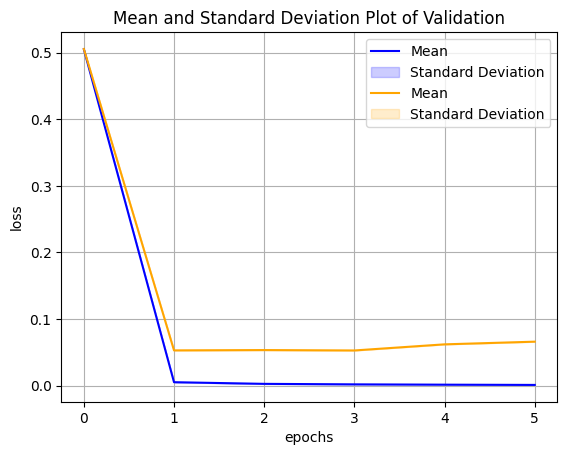

In [26]:
# Plotting
with torch.no_grad():
    plot_mean_and_std(losses_2d, "blue", "Training")
    plot_mean_and_std(val_losses_2d, "orange", "Validation")

In [27]:
def enhanced_box_plot(data_array):
    """
    Creates a box plot for each column in the given NumPy array and overlays mean and standard deviation.
    
    Parameters:
    - data_array (numpy.ndarray): A 2D NumPy array where each column represents a series of data points.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    # Create the boxplot
    bp = ax.boxplot(data_array, patch_artist=True, notch=True, meanline=True)
    
    # Calculate means and standard deviations
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    n_cols = data_array.shape[1]

    # Add mean and standard deviation lines
    for i in range(n_cols):
        # Mean line
        plt.plot([i+1], [means[i]], color='red', marker='o', markersize=5)
        # Standard deviation lines
        plt.plot([i+1, i+1], [means[i] - stds[i], means[i] + stds[i]], color='purple', marker='_', markersize=10, linestyle='None')

    # Customizing the plot
    plt.title('Box Plot with Mean and Standard Deviation')
    plt.xlabel('Column Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# enhanced_box_plot(train_data[:, 0::2])

In [28]:
np.mean(x_train, axis=0)

array([0.5131227 , 0.49279608, 0.50595017, 0.49696724, 0.56815905,
       0.43005692, 0.49535263, 0.50871915, 0.45532862, 0.53776615,
       0.52524578, 0.47288624, 0.51803029, 0.48480317, 0.54777782,
       0.45190736, 0.47984638, 0.52149688, 0.51202244, 0.48396875,
       0.57102422, 0.43262779, 0.48593771, 0.51330671, 0.52300982,
       0.47707413, 0.55293792, 0.4534636 ])

Error Plots

In [29]:
def impute_with_column_mean(data):
    """
    Imputes missing values (represented as 0) in a DataFrame with the mean of the non-zero values in the same column.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed using column means.
    """
    # Replace '0' with NaN to handle them as missing values
    imputed_data = data.replace(0, np.nan)
    
    # Calculate the mean of each column, ignoring NaNs
    column_means = imputed_data.mean()
    
    # Replace NaN values in each column with the mean of that column
    imputed_data.fillna(column_means, inplace=True)

    return imputed_data

In [30]:
def impute_with_row_average(data):
    """
    Imputes missing values (NaN) in a DataFrame with the average of the non-missing values in the same row.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    imputed_data = data.copy()
    # Replace '0' with NaN to handle them as missing values
    imputed_data = data.replace(0, np.nan)

    # Iterate over each row
    for index, row in imputed_data.iterrows():
        # Calculate the mean of the non-NaN values in the row
        mean_value = row[row.index.difference(["patient_id"])].mean()

        # Replace NaN values in the row with the calculated mean
        imputed_data.loc[index] = row.fillna(mean_value)

    return imputed_data

In [31]:
# mode = other => impute by average of other domains, mode = data => impute by average of the data set
def imputation(data, mode=""):
    if mode == "other":
        return impute_with_row_average(data)
    elif mode == "data":
        return impute_with_column_mean(data)

In [32]:
# get predictions from the model
def predict(data, model):
    model.eval()
    data_t = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        return model(data).clone().detach().numpy()

In [33]:
test_data

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
1326776,0.657,0.35,0.613,0.600,0.340,0.600,0.61,0.917,0.350,0.829,0.56,0.493,0.218,1.000
1051680,0.500,1.00,1.000,0.400,0.200,0.842,0.90,1.000,0.700,0.721,1.00,0.464,0.497,1.000
675493,0.457,0.35,0.867,0.257,0.110,0.695,0.65,0.050,0.220,0.464,1.00,0.193,0.491,0.667
676614,0.443,0.50,0.867,0.314,0.140,0.695,0.65,0.050,0.240,0.471,0.72,0.222,0.382,0.667
1183694,1.000,0.80,0.933,1.000,0.700,0.831,0.54,1.000,0.290,0.857,1.00,0.500,0.879,0.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712656,0.314,0.02,0.926,0.388,0.142,0.040,0.52,1.000,0.067,0.493,0.68,0.315,0.622,0.427
893570,0.429,0.61,0.733,0.271,0.090,0.053,0.55,0.017,0.160,0.286,1.00,0.265,0.267,0.667
1257544,0.929,1.00,1.000,0.400,0.240,0.674,0.54,1.000,0.910,0.779,1.00,0.493,0.739,1.000
752284,0.757,1.00,0.787,0.543,0.150,0.632,0.50,1.000,0.620,0.778,1.00,0.307,0.612,0.667


In [49]:
column_names = ["domain %d score" % i for i in range(1, 15)]
accuracy_list_prediction = []
accuracy_list_imputation = []
std_prediction = []
std_imputation = []

In [35]:
def create_new_array_2d(ground_truth, prediction, masked):
    # Ensure all arrays have the same shape
    if ground_truth.shape != prediction.shape or prediction.shape != masked.shape:
        raise ValueError("All arrays must have the same shape")

    # Initialize the new array with the same shape
    new_array = np.empty_like(ground_truth)

    # Iterate through each row
    for i in range(ground_truth.shape[0]):
        # Iterate through each pair of values in the row
        for j in range(0, ground_truth.shape[1], 2):
            pair_masked = masked[i, j:j+2]
            # print(pair_masked)
            # Check if the pair in the masked array is missing
            if pair_masked[0] == pair_masked[1] and (pair_masked[0] == 1 or pair_masked[0] == 0):
                # print(i, j, pair_masked)
                # Use the corresponding pair from the prediction array
                new_array[i, j:j+2] = prediction[i, j:j+2]
            else:
                # Use the corresponding pair from the ground truth array
                new_array[i, j:j+2] = ground_truth[i, j:j+2]

    return new_array

In [50]:
index_list = test_data.index.tolist()
for masked_number in range(0, 15):
    masked_ratio = masked_number / 14
    ## create masked testing data so we can see how the model predicts and how imputation compares
    masked_test_data = generate_mask(test_data[column_names].copy().to_numpy(), ratio=masked_ratio)
    masked_test_data = create_missing_indicator(masked_test_data)

    # predict
    predictions = predict(torch.from_numpy(masked_test_data).float(), model)
    # predictions_indexed = dict(zip(index_list, predictions))
    # predictions = create_new_array_2d(create_missing_indicator(test_data[column_names].copy().to_numpy()), predictions, masked_test_data)

    # impute 
    imputataion_data = imputation(pd.DataFrame(masked_test_data[:, ::2], columns=column_names), mode="data").to_numpy()

    ## get accuracy
    squared_diffs_pred = (predictions[:, ::2] - test_data[column_names].copy().to_numpy()) ** 2
    std_prediction.append(np.std(squared_diffs_pred))
    mse = np.mean(squared_diffs_pred)
    accuracy_list_prediction.append(mse)

    squared_diffs_impute = (imputataion_data - test_data[column_names].copy().to_numpy()) ** 2
    std_imputation.append(np.std(squared_diffs_impute))
    mse = np.mean(squared_diffs_impute)
    accuracy_list_imputation.append(mse)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_85814/426952084.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_t = torch.tensor(data, dtype=torch.float32)
/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_85814/426952084.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_t = torch.tensor(data, dtype=torch.float32)
/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_85814/426952084.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_t = torch.tensor(data, dtype=torch.float32)
/var/folders/vv/

In [51]:
masked_test_data.shape

(40840, 28)

In [52]:
accuracy_list_imputation

[0.0,
 0.011403014823841408,
 0.02271897851057464,
 0.033854754151370126,
 0.045908477633354046,
 0.05826777108826486,
 0.07080294295796875,
 0.08422341108036038,
 0.09909236734309074,
 0.11558399785486996,
 0.1334968430114956,
 0.15617512082356613,
 0.1822364111119871,
 0.21428679653020355,
 0.254997137856793]

In [53]:
accuracy_list_prediction

[0.025403354971587803,
 0.02646444826771496,
 0.027752916555026177,
 0.029647246074720926,
 0.031760011720243876,
 0.03450212733937213,
 0.03810865344795826,
 0.041960824613372305,
 0.046374215589830285,
 0.05183163335842544,
 0.05785597394813279,
 0.06445173419378032,
 0.07225826951138459,
 0.08089145946348586,
 0.09045788448622487]

Visualization

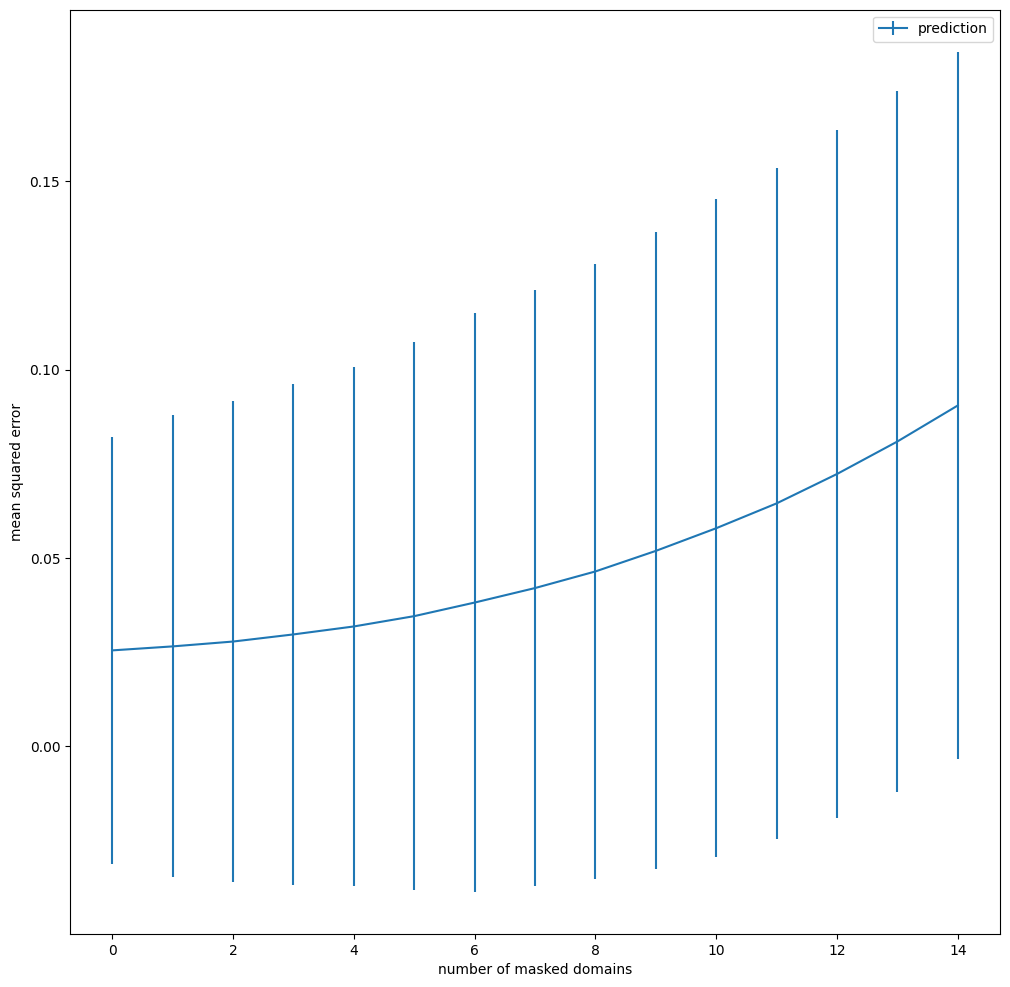

In [57]:
fig = plt.figure(figsize=(12, 12))
plt.errorbar(range(0, 15), accuracy_list_prediction, yerr=std_prediction, label="prediction")
# plt.errorbar(range(0, 15), accuracy_list_imputation, yerr=std_imputation, label="imputation")
plt.xlabel("number of masked domains")
plt.ylabel("mean squared error")
plt.legend()